In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Projet IMMI
## Challenge iSeg2017
Nicolas Boutry

Todd Tavernier

## Introduction
Ce projet consiste à participer au challenge iSeg2017 de segmentation biomédicale en utilisant des réseaux de neurones convolutifs (CNN). Nous allons suivre une méthodologie précise pour entraîner plusieurs modèles de type U-Net afin de segmenter différentes zones d'intérêt dans des images médicales.


## Téléchargement et exploration des données
Nous allons télécharger les données et explorer les images pour comprendre leur structure.


### Chargement et affichage des images des patients

Dans cette première partie, nous chargeons les images des patients six par six, couvrant ainsi toutes les images pour chaque sujet. Pour charger les images d'un patient spécifique, il faut modifier l'argument dans la fonction `all_images = load_subject_images(patient_id)`, où `patient_id` représente l'ID du patient souhaité.

Ensuite, vous pouvez choisir le plan de coupe que vous souhaitez afficher (axial, coronal ou sagittal) en utilisant la fonction `plot_images(plane)`, où `plane` peut être `0` pour le plan axial, `1` pour le plan coronal et `2` pour le plan sagittal. Par exemple, pour afficher les images axiales, utilisez `plot_images(0)`.


In [ ]:
import math
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
import tensorflow as tf
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras



def load_subject_images(subject_number):
    all_images = []
    image_files = [f"subject-{subject_number}-label.img", f"subject-{subject_number}-T1.img", f"subject-{subject_number}-T2.img"]
    for i in range(len(image_files)):
        img_file = '/content/drive/MyDrive/images1/'+image_files[i]
        img_data = nib.load(img_file).get_fdata()
        img_data =  np.reshape(img_data,(img_data.shape[0],img_data.shape[1],img_data.shape[2]))
        if not ("label" in image_files[i]):
            img_data = normalize_image(img_data)
        all_images.append((img_file, img_data))
    return all_images



def plot_images(images, axe):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, num_images*5))
    for i, (img_file, img_data) in enumerate(images):
        if axe == 0:
            axs[i].imshow(img_data[img_data.shape[0] // 2 ,:,:], cmap='gray')
            axs[i].set_title(img_file)
        elif axe == 1:
            axs[i].imshow(img_data[:, img_data.shape[1] // 2, :], cmap='gray')
            axs[i].set_title(img_file)
        else:
            axs[i].imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
            axs[i].set_title(img_file)

### Normalisation des images

La fonction suivante permet de normaliser une image 3D en appliquant une normalisation gaussienne. Tout d'abord, les valeurs négatives de l'image sont mises à zéro pour s'assurer que seules les valeurs positives sont prises en compte. Ensuite, nous calculons la moyenne (`mu`) et l'écart-type (`sigma`) des valeurs de l'image. La normalisation est effectuée en soustrayant la moyenne de chaque pixel et en divisant par cinq fois l'écart-type.


In [ ]:
def normalize_image(image):
    image[image < 0] = 0
    mu = np.mean(image)
    sigma = np.std(image)
    normalized_image = (image - mu) / (5 * sigma)
    return normalized_image

### Chargement et répartition des images

Dans cette section, nous chargeons les images des patients et les répartissons en trois ensembles distincts : entraînement, validation et test.

- **Ensemble d'entraînement** : Nous chargeons les images des patients 1 à 6 et les ajoutons à une liste `training_images`.
- **Ensemble de validation** : Nous chargeons les images des patients 7 et 8 et les ajoutons à une liste `validation_images`.
- **Ensemble de test** : Nous chargeons les images des patients 9 et 10 et les ajoutons à une liste `patient_test_images`.


In [ ]:
training_images=[]
for i in range(1, 7):
    all_images = load_subject_images(i)
    training_images.append(all_images)
validation_images=[]
for i in range(7, 9):
    all_images = load_subject_images(i)
    validation_images.append(all_images)
patient_test_images=[]
for i in range(9, 11):
    all_images = load_subject_images(i)
    patient_test_images.append(all_images)

### Formatage des données en mode 2D

Pour entraîner notre modèle U-Net avec seulement 10 patients, nous devons extraire les coupes 2D pertinentes des images 3D des patients. La fonction suivante, `format_data`, permet de réaliser ce formatage en sélectionnant uniquement les coupes 2D contenant une quantité suffisante de cerveau pour que les T1/T2 correspondantes aient un sens pour le réseau.

#### Étapes de la fonction `format_data`

1. **Calcul du nombre de coupes pertinentes** :
   - Nous itérons sur chaque patient et chaque coupe en z de la vérité terrain (VT).
   - Si une coupe contient plus de 100 pixels pertinents (non-background), elle est considérée comme pertinente.
   - Nous comptons le nombre total de coupes pertinentes (`NBCOUPES`).

2. **Initialisation des matrices de données** :
   - Nous créons des matrices `XTRAIN` et `YTRAIN` pour stocker les données d'entraînement. `XTRAIN` contient les images T1 et T2 normalisées, et `YTRAIN` contient les vérités terrain binarisées.

3. **Remplissage des matrices de données** :
   - Nous itérons à nouveau sur chaque patient et chaque coupe en z.
   - Si une coupe est pertinente, nous stockons les images T1 et T2 normalisées dans `XTRAIN` et la vérité terrain binarisée dans `YTRAIN`.

4. **Retour des matrices de données** :
   - Les matrices `XTRAIN` et `YTRAIN` sont renvoyées pour être utilisées dans l'entraînement du modèle.


In [ ]:
def format_data(patients):
    NBCOUPES =0
    for patient in patients:
        VT= patient[0][1]
        for z in range(VT.shape[2]):
            immage = VT[:, :, z]
            if np.sum(np.where(immage > 0, 1, 0)) > 100:
                NBCOUPES += 1

    XTRAIN = np.zeros((NBCOUPES,VT.shape[0], VT.shape[1], 2))
    YTRAIN = np.zeros((NBCOUPES, VT.shape[0], VT.shape[1]))
    num =0
    for patient in patients:
        T1= patient[1][1]
        T2= patient[2][1]
        VT= patient[0][1]
        for z in range(VT.shape[2]):
            immage = VT[:, :, z]
            if np.sum(np.where(immage > 0, 1, 0)) > 100:
                XTRAIN[num, :, :, 0] = T2[:, :, z]
                XTRAIN[num, :, :, 1] = T1[:, :, z]
                YTRAIN[num, :, :] = np.where(immage > 0, 1, 0)
                num += 1
    return XTRAIN, YTRAIN

XTRAIN, YTRAIN = format_data(training_images)
XVALID, YVALID = format_data(validation_images)


### Définition et entraînement du modèle U-Net

Dans cette section, nous chargeons un modèle de réseau de neurones convolutifs (CNN) de type U-Net pour la tâche de segmentation.
#### Explication du modèle U-Net
1. **Entrée du modèle** : Définie par la variable `input_size`, qui spécifie la taille des images d'entrée.
2. **Bloc de convolution et de pooling** :
   - Chaque bloc de convolution consiste en deux couches de convolution avec activation ReLU et initialisation des poids selon He normal.
   - Les couches de pooling réduisent la dimension spatiale des caractéristiques extraites.
3. **Couches centrales** : Augmentation du nombre de filtres pour extraire des caractéristiques plus complexes.
4. **Bloc d'up-sampling et de convolution** :
   - Chaque bloc d'up-sampling double la dimension spatiale des caractéristiques.
   - Les couches de convolution réduisent le nombre de filtres pour reconstruire l'image segmentée.
5. **Couches de sortie** : Une couche de convolution finale avec une activation sigmoïde pour produire la segmentation binaire.


In [ ]:
def unet(pretrained_weights = None,input_size = (32,32,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()


    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



###Entraînement du modèle
Nous initialisons le modèle avec la taille d'entrée appropriée et définissons un callback pour l'arrêt anticipé (EarlyStopping). Ensuite, nous testons le modèle en effectuant une prédiction sur une image de l'ensemble d'entraînement et affichons le résultat.

1/1 [==============================] - 3s 3s/step
(144, 192)


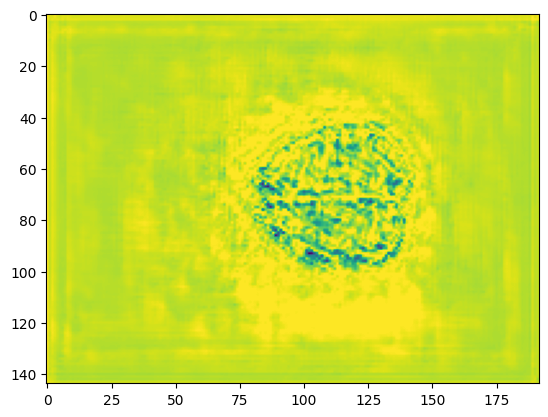

Epoch 1/60
60/60 [==============================] - 19s 83ms/step - loss: 0.3064 - accuracy: 0.8012 - val_loss: 0.2000 - val_accuracy: 0.9940
Epoch 2/60
60/60 [==============================] - 2s 39ms/step - loss: 0.2000 - accuracy: 0.9950 - val_loss: 0.1886 - val_accuracy: 0.9970
Epoch 3/60
60/60 [==============================] - 2s 38ms/step - loss: 0.1894 - accuracy: 0.9979 - val_loss: 0.1795 - val_accuracy: 0.9986
Epoch 4/60
60/60 [==============================] - 2s 41ms/step - loss: 0.1806 - accuracy: 0.9989 - val_loss: 0.1715 - val_accuracy: 0.9988
Epoch 5/60
60/60 [==============================] - 2s 40ms/step - loss: 0.1726 - accuracy: 0.9993 - val_loss: 0.1640 - val_accuracy: 0.9994
Epoch 6/60
60/60 [==============================] - 3s 42ms/step - loss: 0.1653 - accuracy: 0.9995 - val_loss: 0.1574 - val_accuracy: 0.9991
Epoch 7/60
60/60 [==============================] - 2s 39ms/step - loss: 0.1583 - accuracy: 0.9997 - val_loss: 0.1505 - val_accuracy: 0.9995
Epoch 8/60
6

In [ ]:
model = unet(input_size=(144,192,2))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
first_predict = model.predict(np.reshape(XTRAIN[100, :, :, :], (1, XTRAIN.shape[1], XTRAIN.shape[2], XTRAIN.shape[3])))
first_predict = np.reshape(first_predict, (first_predict.shape[1], first_predict.shape[2]))
print(first_predict.shape)
plt.imshow(first_predict)
plt.show()
model.fit(XTRAIN, YTRAIN, batch_size=10, epochs=60, validation_data=(XVALID, YVALID), callbacks=[es])

### Prédiction et évaluation des performances

Dans cette section, nous définissons les fonctions nécessaires pour effectuer des prédictions sur les images de test et évaluer les performances du modèle.

#### Fonction `waterfall_predict`

La fonction `waterfall_predict` permet d'effectuer des prédictions sur les images de test. Voici les étapes principales de cette fonction :

1. **Initialisation** :
   - Nous créons des listes pour stocker les prédictions et initialisons des matrices pour les images T1 et T2, ainsi que pour les vérités terrain (VTerrain) et les prédictions finales.

2. **Prédictions par coupe** :
   - Pour chaque coupe en z des images T1 et T2, nous formons un ensemble de test `XTEST` avec les images normalisées.
   - Nous utilisons le modèle pour prédire la segmentation sur chaque coupe, puis nous stockons les résultats dans la matrice `final`.

3. **Calcul du score de Dice** :
   - Nous comparons les prédictions avec les vérités terrain en calculant le score de Dice, une métrique utilisée pour évaluer la similarité entre deux ensembles binaires.

###Stockage des prédictions :
   - Les prédictions finales pour chaque patient sont stockées dans la liste `predict2d`.


In [ ]:
def waterfall_predict(patient_test_images):
    prediction = []
    for patient in patient_test_images:
        T1 = patient[1][1]
        T2 = patient[2][1]
        print(patient[0][0])
        final = np.zeros((T1.shape[0], T1.shape[1], T1.shape[2]))
        VTerrain = np.zeros((T1.shape[0], T1.shape[1], T1.shape[2]))
        XTEST = np.zeros((1,T1.shape[0], T1.shape[1], 2))
        for z in range(T1.shape[2]):
            XTEST[0, :, :, 0] = T2[:, :, z]
            XTEST[0, :, :, 1] = T1[:, :, z]
            predict = model.predict(XTEST,verbose =0)
            predict = np.reshape(predict, (predict.shape[1], predict.shape[2]))
            final[:, :, z] = np.where(predict > 0.5, 1, 0)
            VTerrain[:, :, z] = np.where((patient[0][1])[:, :, z] > 0, 1, 0)
        print(dice(final, VTerrain))
        prediction.append(final)
    return prediction


def dice(predict, truth):
    return (np.sum(predict * truth) * 2 / (np.sum(predict) + np.sum(truth)))

predict2d = waterfall_predict(patient_test_images)


/content/drive/MyDrive/images1/subject-9-label.img
0.9999641103635738
/content/drive/MyDrive/images1/subject-10-label.img
0.9999859493897018


### Formatage des données en mode 3 canaux

Dans cette section, nous définissons la fonction `format_data_3channels`, qui permet de formater les données des patients en utilisant trois canaux d'entrée pour le modèle U-Net. Cette approche inclut les prédictions du modèle précédent en tant que troisième canal d'entrée.

#### Étapes de la fonction `format_data_3channels`

1. **Calcul du nombre de coupes pertinentes** :
   - Nous itérons sur chaque patient et chaque coupe en z de la vérité terrain (VT).
   - Si une coupe contient plus de 100 pixels pertinents (non-background), elle est considérée comme pertinente.
   - Nous comptons le nombre total de coupes pertinentes (`NBCOUPES`).

2. **Initialisation des matrices de données** :
   - Nous créons des matrices `XTRAIN` et `YTRAIN` pour stocker les données d'entraînement. `XTRAIN` contient les images T1 et T2 normalisées, ainsi que les prédictions du modèle précédent. `YTRAIN` contient les vérités terrain binarisées.

3. **Prédictions du modèle précédent** :
   - Nous utilisons la fonction `waterfall_predict` pour obtenir les prédictions du modèle précédent pour chaque patient.

4. **Remplissage des matrices de données** :
   - Nous itérons à nouveau sur chaque patient et chaque coupe en z.
   - Si une coupe est pertinente, nous stockons les images T1 et T2 normalisées, ainsi que les prédictions du modèle précédent dans `XTRAIN`, et la vérité terrain binarisée dans `YTRAIN`.

5. **Retour des matrices de données** :
   - Les matrices `XTRAIN` et `YTRAIN` sont renvoyées pour être utilisées dans l'entraînement du modèle.


In [ ]:
def format_data_3channels(patients):
    NBCOUPES =0
    for patient in patients:
        VT= patient[0][1]
        for z in range(VT.shape[2]):
            immage = VT[:, :, z]
            if np.sum(np.where(immage > 0, 1, 0)) > 100:
                NBCOUPES += 1

    XTRAIN = np.zeros((NBCOUPES,VT.shape[0], VT.shape[1], 3))
    YTRAIN = np.zeros((NBCOUPES, VT.shape[0], VT.shape[1]))
    num =0
    predicts = waterfall_predict(patients)
    index = 0
    for patient in patients:
        T1= patient[1][1]
        T2= patient[2][1]
        VT= patient[0][1]
        for z in range(VT.shape[2]):
            immage = VT[:, :, z]
            if np.sum(np.where(immage > 0, 1, 0)) > 100:
                XTRAIN[num, :, :, 0] = T2[:, :, z]
                XTRAIN[num, :, :, 1] = T1[:, :, z]
                XTRAIN[num, :, :, 2] = np.where(predicts[index][:, :, z] > 0.5 ,1 ,0)
                YTRAIN[num, :, :] = np.where(VT[:, :, z] > 10, 1, 0)
                num += 1
        index+=1
    return XTRAIN, YTRAIN

# Application de la fonction pour formater les données d'entraînement et de validation
XTRAIN_3, YTRAIN_3 = format_data_3channels(training_images)

XVALID_3, YVALID_3 = format_data_3channels(validation_images)

/content/drive/MyDrive/images1/subject-1-label.img
0.9999994573607656
/content/drive/MyDrive/images1/subject-2-label.img
0.9999980315309375
/content/drive/MyDrive/images1/subject-3-label.img
0.9999932148481329
/content/drive/MyDrive/images1/subject-4-label.img
1.0
/content/drive/MyDrive/images1/subject-5-label.img
0.9999982778385956
/content/drive/MyDrive/images1/subject-6-label.img
0.9999986973280897
/content/drive/MyDrive/images1/subject-7-label.img
0.9999625072076661
/content/drive/MyDrive/images1/subject-8-label.img
0.9999904662087481


### Définition et compilation du modèle U-Net 3D

Dans cette section, nous chargeons un modèle de réseau de neurones convolutifs (CNN) de type U-Net en 3D pour la tâche de segmentation d'images. Ce modèle est basé sur l'architecture classique du U-Net, adaptée pour traiter des volumes en 3D.

#### Définition du modèle U-Net 3D

La fonction `unet_3d` définit l'architecture du modèle. Voici les principales étapes de la construction du modèle :

1. **Entrée du modèle** : Définie par la variable `input_size`, qui spécifie la taille des images d'entrée.
2. **Blocs de convolution et de pooling** :
   - Chaque bloc de convolution consiste en deux couches de convolution avec activation ReLU et initialisation des poids selon He normal.
   - Les couches de pooling réduisent la dimension spatiale des caractéristiques extraites.
3. **Couches centrales** : Augmentation du nombre de filtres pour extraire des caractéristiques plus complexes.
4. **Blocs d'up-sampling et de convolution** :
   - Chaque bloc d'up-sampling double la dimension spatiale des caractéristiques.
   - Les couches de convolution réduisent le nombre de filtres pour reconstruire l'image segmentée.
5. **Couches de sortie** : Une couche de convolution finale avec une activation sigmoïde pour produire la segmentation binaire.


In [ ]:
def unet_3d(pretrained_weights = None,input_size = (32,32,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()


    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


### Initialisation, prédiction initiale et entraînement du modèle U-Net 3D

Dans cette section, nous initialisons le modèle U-Net 3D avec trois canaux d'entrée, effectuons une prédiction initiale pour visualiser les résultats, puis entraînons le modèle sur les données d'entraînement et de validation.

#### Initialisation du modèle U-Net 3D

Nous initialisons le modèle U-Net 3D en spécifiant la taille d'entrée comme `(144, 192, 3)`, correspondant à la hauteur, la largeur et le nombre de canaux (T1, T2 et les prédictions du modèle précédent).

###Prédiction initiale
Pour vérifier que le modèle fonctionne correctement, nous effectuons une prédiction initiale sur une image de l'ensemble d'entraînement. Nous sélectionnons une image, la redimensionnons et l'utilisons pour obtenir une prédiction du modèle.

###Entraînement du modèle
Nous entraînons ensuite le modèle en utilisant les ensembles de données d'entraînement et de validation. Le callback EarlyStopping est utilisé pour surveiller la perte de validation (val_loss) et arrêter l'entraînement si la perte ne s'améliore pas après 6 époques, tout en restaurant les meilleurs poids du modèle.

1/1 [==============================] - 0s 439ms/step
(144, 192)


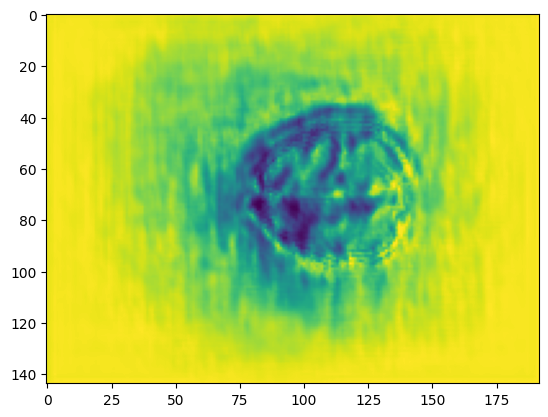

Epoch 1/65
60/60 [==============================] - 11s 58ms/step - loss: 0.2677 - accuracy: 0.8622 - val_loss: 0.1886 - val_accuracy: 0.9561
Epoch 2/65
60/60 [==============================] - 3s 43ms/step - loss: 0.1841 - accuracy: 0.9591 - val_loss: 0.1736 - val_accuracy: 0.9685
Epoch 3/65
60/60 [==============================] - 2s 39ms/step - loss: 0.1539 - accuracy: 0.9555 - val_loss: 0.1006 - val_accuracy: 0.9560
Epoch 4/65
60/60 [==============================] - 2s 40ms/step - loss: 0.0781 - accuracy: 0.9668 - val_loss: 0.0633 - val_accuracy: 0.9728
Epoch 5/65
60/60 [==============================] - 2s 40ms/step - loss: 0.0559 - accuracy: 0.9756 - val_loss: 0.0498 - val_accuracy: 0.9777
Epoch 6/65
60/60 [==============================] - 2s 41ms/step - loss: 0.0469 - accuracy: 0.9781 - val_loss: 0.0476 - val_accuracy: 0.9775
Epoch 7/65
60/60 [==============================] - 3s 45ms/step - loss: 0.0450 - accuracy: 0.9787 - val_loss: 0.0456 - val_accuracy: 0.9781
Epoch 8/65
6

In [ ]:
model_3d = unet_3d(input_size=(144,192,3))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
first_predict = model_3d.predict(np.reshape(XTRAIN_3[100, :, :, :], (1, XTRAIN_3.shape[1], XTRAIN_3.shape[2], XTRAIN_3.shape[3])))
first_predict = np.reshape(first_predict, (first_predict.shape[1], first_predict.shape[2]))
print(first_predict.shape)
plt.imshow(first_predict)
plt.show()
model_3d.fit(XTRAIN_3, YTRAIN_3, batch_size=10, epochs=65, validation_data=(XVALID_3, YVALID_3), callbacks=[es])

### Prédiction finale avec le modèle U-Net 3D

Dans cette section, nous définissons la fonction `second_waterfall_predict`, qui utilise le modèle U-Net 3D pour effectuer des prédictions sur les images de test. Cette fonction inclut les prédictions du modèle 2D en tant que troisième canal d'entrée, en plus des images T1 et T2.

#### Fonction `second_waterfall_predict`

La fonction `second_waterfall_predict` permet d'effectuer des prédictions sur les images de test en utilisant le modèle U-Net 3D. Voici les étapes principales de cette fonction :

1. **Initialisation** :
   - Nous créons des listes pour stocker les prédictions et initialisons des matrices pour les images T1 et T2, ainsi que pour les vérités terrain (VTerrain) et les prédictions finales.

2. **Visualisation des prédictions 2D** :
   - Pour chaque patient, nous visualisons les prédictions 2D obtenues précédemment au milieu de l'image pour vérifier leur cohérence.

3. **Prédictions par coupe** :
   - Pour chaque coupe en z des images T1 et T2, nous formons un ensemble de test `XTEST` avec les images normalisées et les prédictions 2D.
   - Nous utilisons le modèle 3D pour prédire la segmentation sur chaque coupe, puis nous stockons les résultats dans la matrice `final`.

4. **Calcul du score de Dice** :
   - Nous comparons les prédictions avec les vérités terrain en calculant le score de Dice, une métrique utilisée pour évaluer la similarité entre deux ensembles binaires.

###Stockage des prédictions :
   - Les prédictions finales pour chaque patient sont stockées dans la liste `predict3d`.


/content/drive/MyDrive/images1/subject-9-label.img


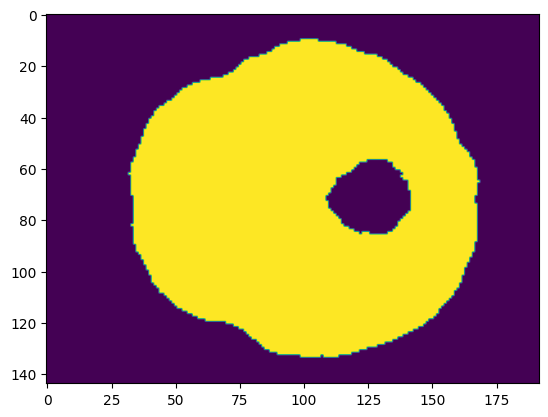

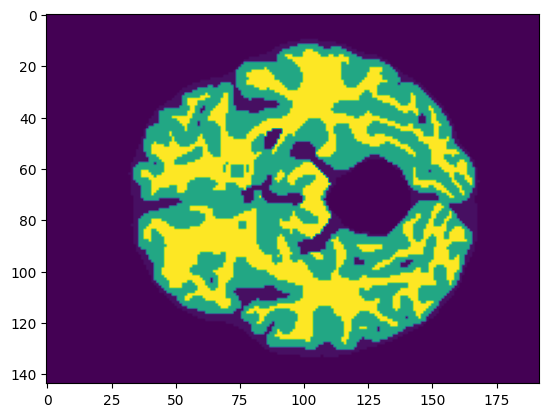

0.9785740847359558
/content/drive/MyDrive/images1/subject-10-label.img


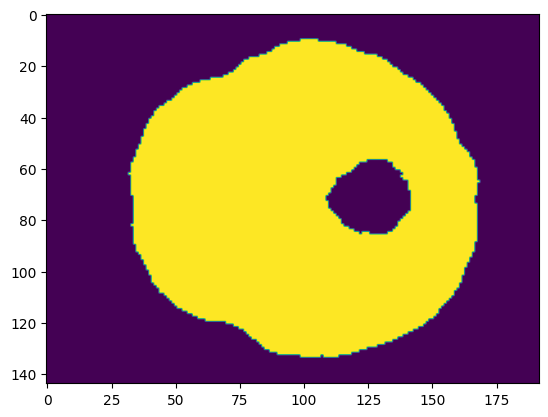

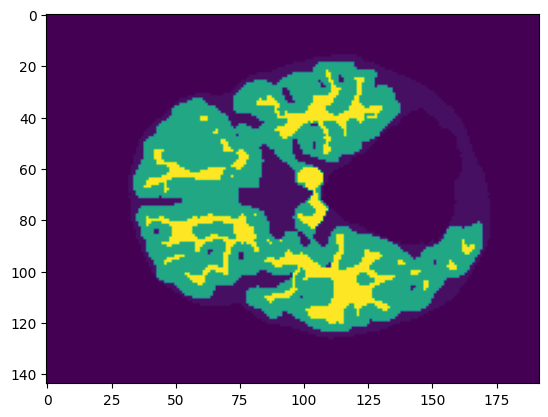

0.9634520230585831


In [ ]:
def second_waterfall_predict(patient_test_images):
    prediction = []
    for patient in patient_test_images:
        T1 = patient[1][1]
        T2 = patient[2][1]
        print(patient[0][0])
        final = np.zeros((T1.shape[0], T1.shape[1], T1.shape[2]))
        VTerrain = np.zeros((T1.shape[0], T1.shape[1], T1.shape[2]))
        XTEST = np.zeros((1,T1.shape[0], T1.shape[1], 3))
        index = 0
        predire = predict2d[index]
        plt.imshow(predire[:, :, patient[0][1].shape[2]//2])
        plt.show()
        plt.imshow(patient[0][1][:, :, patient[0][1].shape[2]//2])
        plt.show()
        for z in range(T1.shape[2]):
            XTEST[0, :, :, 0] = T2[:, :, z]
            XTEST[0, :, :, 1] = T1[:, :, z]
            XTEST[0, :, :, 2] = predire[:, :, z]
            predict = model_3d.predict(XTEST,verbose =0)
            predict = np.reshape(predict, (predict.shape[1], predict.shape[2]))
            final[:, :, z] = np.where(predict > 0.5, 1, 0)
            VTerrain[:, :, z] = np.where((patient[0][1])[:, :, z] > 10, 1, 0)
        print(dice(final, VTerrain))
        index+=1
        prediction.append(final)
    return prediction

predict3d = second_waterfall_predict(patient_test_images)

### Formatage des données en mode 4 canaux

Dans cette section, nous définissons la fonction `format_data_4channels`, qui permet de formater les données des patients en utilisant quatre canaux d'entrée pour le modèle U-Net. Cette approche inclut les prédictions des modèles précédents en tant que troisième et quatrième canaux d'entrée.

#### Étapes de la fonction `format_data_4channels`

1. **Calcul du nombre de coupes pertinentes** :
   - Nous itérons sur chaque patient et chaque coupe en z de la vérité terrain (VT).
   - Si une coupe contient plus de 100 pixels pertinents (non-background), elle est considérée comme pertinente.
   - Nous comptons le nombre total de coupes pertinentes (`NBCOUPES`).

2. **Initialisation des matrices de données** :
   - Nous créons des matrices `XTRAIN` et `YTRAIN` pour stocker les données d'entraînement. `XTRAIN` contient les images T1 et T2 normalisées, ainsi que les prédictions des modèles précédents. `YTRAIN` contient les vérités terrain binarisées.

3. **Prédictions des modèles précédents** :
   - Nous utilisons les fonctions `waterfall_predict` et `second_waterfall_predict` pour obtenir les prédictions des modèles précédents pour chaque patient.

4. **Remplissage des matrices de données** :
   - Nous itérons à nouveau sur chaque patient et chaque coupe en z.
   - Si une coupe est pertinente, nous stockons les images T1 et T2 normalisées, ainsi que les prédictions des modèles précédents dans `XTRAIN`, et la vérité terrain binarisée dans `YTRAIN`.

5. **Retour des matrices de données** :
   - Les matrices `XTRAIN` et `YTRAIN` sont renvoyées pour être utilisées dans l'entraînement du modèle.


/content/drive/MyDrive/images1/subject-1-label.img
0.9999994573607656
/content/drive/MyDrive/images1/subject-2-label.img
0.9999980315309375
/content/drive/MyDrive/images1/subject-3-label.img
0.9999932148481329
/content/drive/MyDrive/images1/subject-4-label.img
1.0
/content/drive/MyDrive/images1/subject-5-label.img
0.9999982778385956
/content/drive/MyDrive/images1/subject-6-label.img
0.9999986973280897
/content/drive/MyDrive/images1/subject-1-label.img


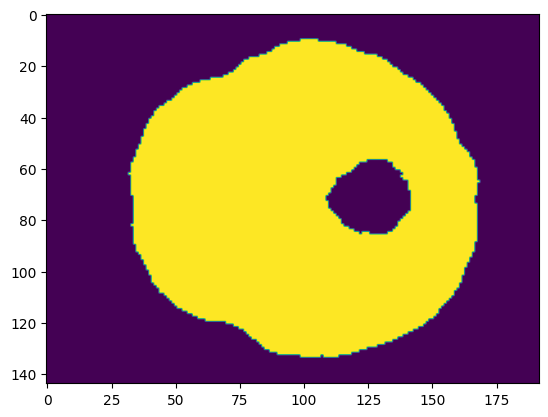

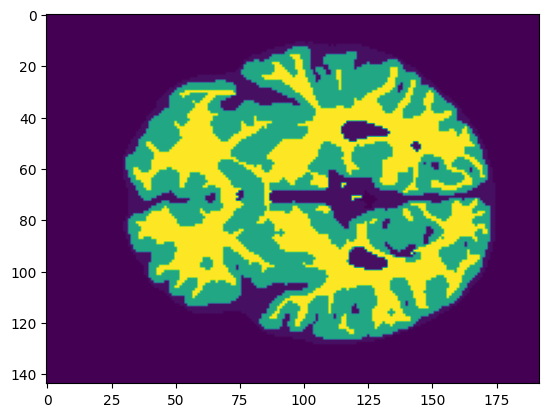

0.9044702805406651
/content/drive/MyDrive/images1/subject-2-label.img


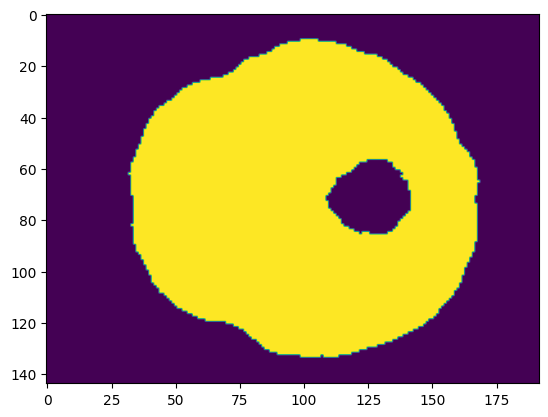

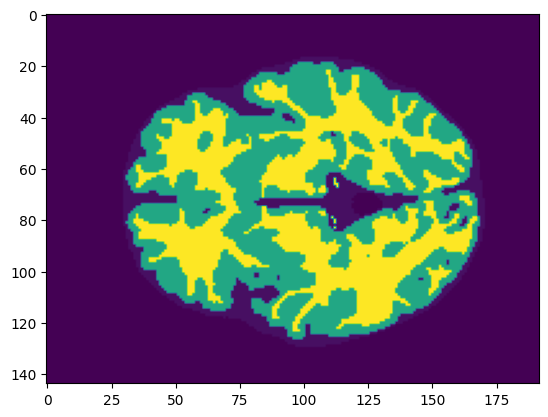

0.9442505727855048
/content/drive/MyDrive/images1/subject-3-label.img


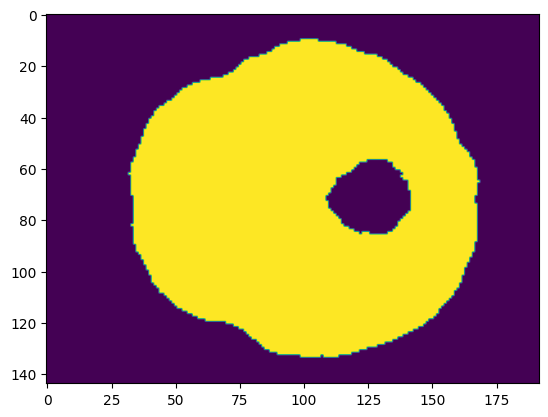

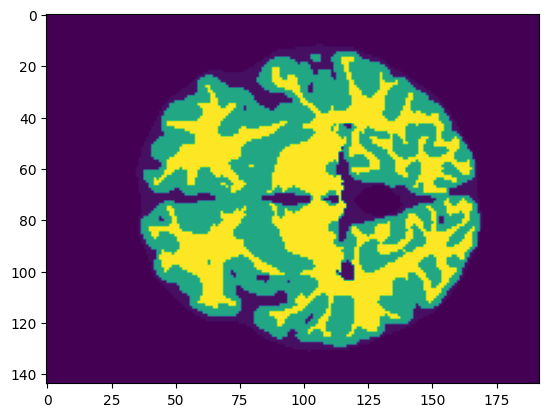

0.9445362481181154
/content/drive/MyDrive/images1/subject-4-label.img


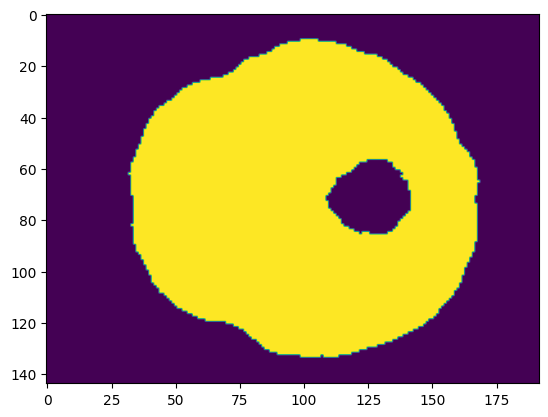

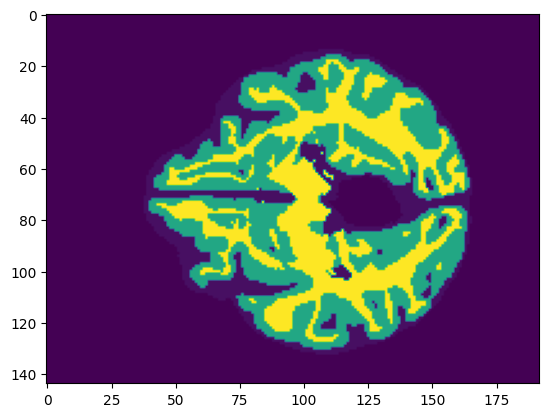

0.955763569489606
/content/drive/MyDrive/images1/subject-5-label.img


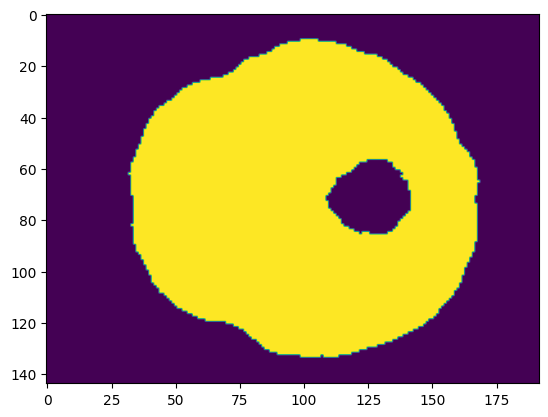

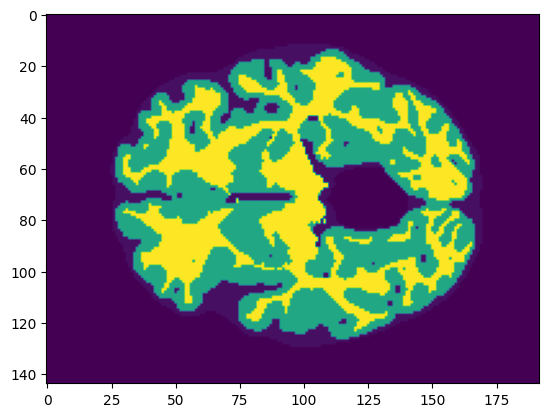

0.9618736947734696
/content/drive/MyDrive/images1/subject-6-label.img


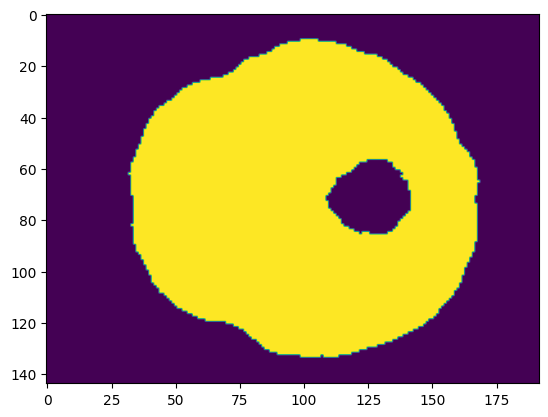

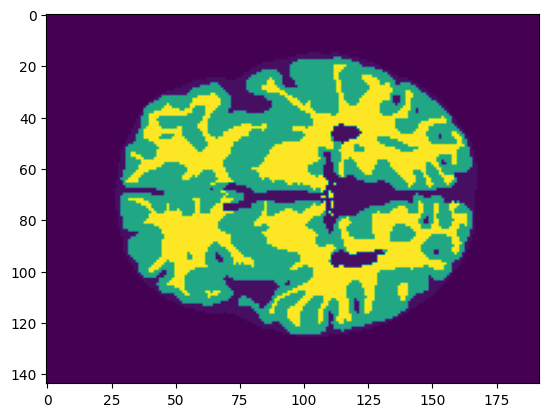

0.9311664841905315
/content/drive/MyDrive/images1/subject-7-label.img
0.9999625072076661
/content/drive/MyDrive/images1/subject-8-label.img
0.9999904662087481
/content/drive/MyDrive/images1/subject-7-label.img


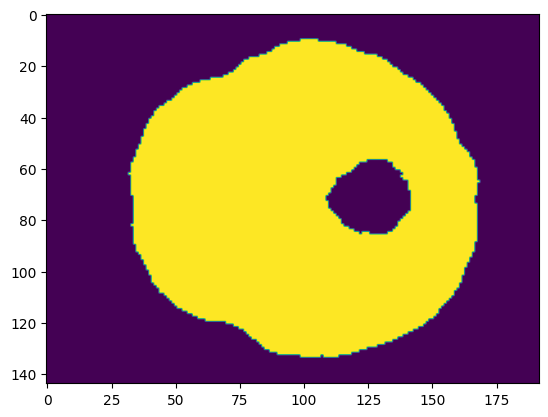

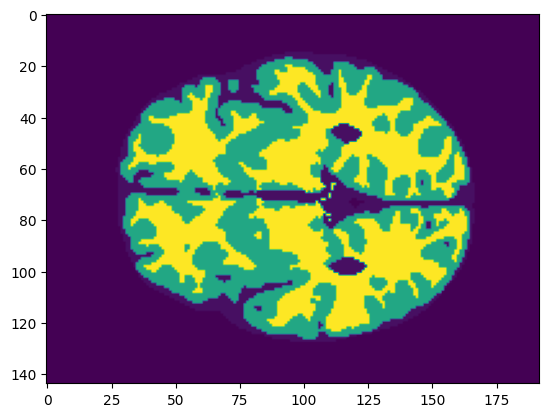

0.9337536073985978
/content/drive/MyDrive/images1/subject-8-label.img


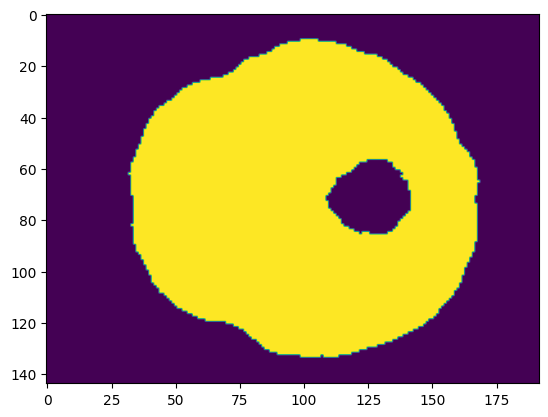

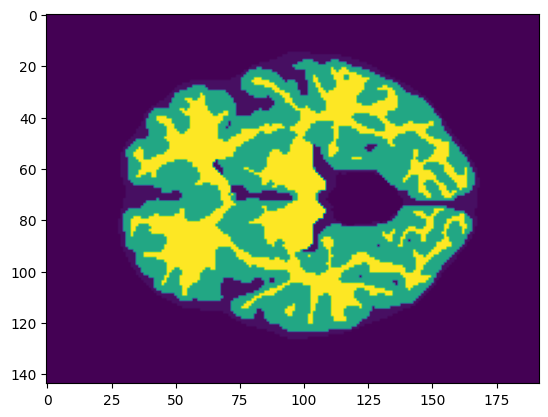

0.9647172757311157


In [ ]:
def format_data_4channels(patients):
    NBCOUPES =0
    for patient in patients:
        VT= patient[0][1]
        for z in range(VT.shape[2]):
            immage = VT[:, :, z]
            if np.sum(np.where(immage > 0, 1, 0)) > 100:
                NBCOUPES += 1

    XTRAIN = np.zeros((NBCOUPES,VT.shape[0], VT.shape[1], 4))
    YTRAIN = np.zeros((NBCOUPES, VT.shape[0], VT.shape[1]))
    num =0
    predicts = waterfall_predict(patients)
    predict3d = second_waterfall_predict(patients)
    index = 0
    for patient in patients:
        T1= patient[1][1]
        T2= patient[2][1]
        VT= patient[0][1]
        for z in range(VT.shape[2]):
            immage = VT[:, :, z]
            if np.sum(np.where(immage > 0, 1, 0)) > 100:
                XTRAIN[num, :, :, 0] = T2[:, :, z]
                XTRAIN[num, :, :, 1] = T1[:, :, z]
                XTRAIN[num, :, :, 2] = np.where(predicts[index][:, :, z] > 0.5 ,1 ,0)
                XTRAIN[num, :, :, 3] = np.where(predict3d[index][:, :, z] > 0.5 ,1 ,0)
                YTRAIN[num, :, :] = np.where(VT[:, :, z] > 150, 1, 0)
                num += 1
        index+=1
    return XTRAIN, YTRAIN

# Application de la fonction pour formater les données d'entraînement et de validation
XTRAIN_4, YTRAIN_4 = format_data_4channels(training_images)

XVALID_4, YVALID_4 = format_data_4channels(validation_images)

### Définition et compilation du modèle U-Net avec quatre canaux d'entrée

Dans cette section, nous chargeons un modèle de réseau de neurones convolutifs (CNN) de type U-Net avec quatre canaux d'entrée pour la segmentation d'images.

#### Définition du modèle U-Net 4D

La fonction `unet_4d` définit l'architecture du modèle. Voici les principales étapes de la construction du modèle :

1. **Entrée du modèle** : Définie par la variable `input_size`, qui spécifie la taille des images d'entrée.
2. **Blocs de convolution et de pooling** :
   - Chaque bloc de convolution consiste en deux couches de convolution avec activation ReLU et initialisation des poids selon He normal.
   - Les couches de pooling réduisent la dimension spatiale des caractéristiques extraites.
3. **Couches centrales** : Augmentation du nombre de filtres pour extraire des caractéristiques plus complexes.
4. **Blocs d'up-sampling et de convolution** :
   - Chaque bloc d'up-sampling double la dimension spatiale des caractéristiques.
   - Les couches de convolution réduisent le nombre de filtres pour reconstruire l'image segmentée.
5. **Couches de sortie** : Une couche de convolution finale avec une activation sigmoïde pour produire la segmentation binaire.


In [ ]:
def unet_4d(pretrained_weights = None,input_size = (32,32,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()


    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



### Initialisation, prédiction initiale et entraînement du modèle U-Net avec quatre canaux d'entrée

Dans cette section, nous initialisons le modèle U-Net avec quatre canaux d'entrée, effectuons une prédiction initiale pour visualiser les résultats, puis entraînons le modèle sur les données d'entraînement et de validation.

#### Initialisation du modèle U-Net 4D

Nous initialisons le modèle U-Net 4D en spécifiant la taille d'entrée comme `(144, 192, 4)`, correspondant à la hauteur, la largeur et le nombre de canaux (T1, T2 et les prédictions des modèles précédents).

###Prédiction initiale
Pour vérifier que le modèle fonctionne correctement, nous effectuons une prédiction initiale sur une image de l'ensemble d'entraînement. Nous sélectionnons une image, la redimensionnons et l'utilisons pour obtenir une prédiction du modèle. La prédiction est ensuite affichée pour visualisation.

###Entraînement du modèle
Nous entraînons ensuite le modèle en utilisant les ensembles de données d'entraînement et de validation. Le callback EarlyStopping est utilisé pour surveiller la perte de validation (val_loss) et arrêter l'entraînement si la perte ne s'améliore pas après 6 époques, tout en restaurant les meilleurs poids du modèle.

1/1 [==============================] - 0s 294ms/step
(144, 192)


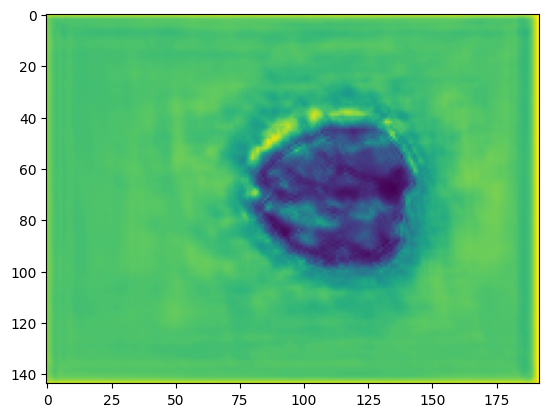

Epoch 1/60
60/60 [==============================] - 11s 57ms/step - loss: 0.1898 - accuracy: 0.9101 - val_loss: 0.1396 - val_accuracy: 0.9122
Epoch 2/60
60/60 [==============================] - 2s 41ms/step - loss: 0.1382 - accuracy: 0.9103 - val_loss: 0.1312 - val_accuracy: 0.9156
Epoch 3/60
60/60 [==============================] - 3s 43ms/step - loss: 0.1317 - accuracy: 0.9273 - val_loss: 0.1281 - val_accuracy: 0.9351
Epoch 4/60
60/60 [==============================] - 2s 41ms/step - loss: 0.1249 - accuracy: 0.9418 - val_loss: 0.1294 - val_accuracy: 0.9284
Epoch 5/60
60/60 [==============================] - 3s 45ms/step - loss: 0.1218 - accuracy: 0.9462 - val_loss: 0.1124 - val_accuracy: 0.9536
Epoch 6/60
60/60 [==============================] - 3s 43ms/step - loss: 0.1134 - accuracy: 0.9544 - val_loss: 0.1067 - val_accuracy: 0.9583
Epoch 7/60
60/60 [==============================] - 2s 42ms/step - loss: 0.1107 - accuracy: 0.9562 - val_loss: 0.1067 - val_accuracy: 0.9588
Epoch 8/60
6

In [ ]:
model_4d = unet_4d(input_size=(144,192,4))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
first_predict = model_4d.predict(np.reshape(XTRAIN_4[100, :, :, :], (1, XTRAIN_4.shape[1], XTRAIN_4.shape[2], XTRAIN_4.shape[3])))
first_predict = np.reshape(first_predict, (first_predict.shape[1], first_predict.shape[2]))
print(first_predict.shape)
plt.imshow(first_predict)
plt.show()
model_4d.fit(XTRAIN_4, YTRAIN_4, batch_size=10, epochs=60, validation_data=(XVALID_4, YVALID_4), callbacks=[es])

### Prédiction finale avec le modèle U-Net 4D

Dans cette section, nous définissons la fonction `third_waterfall_predict`, qui utilise le modèle U-Net 4D pour effectuer des prédictions sur les images de test. Cette fonction inclut les prédictions des modèles précédents en tant que troisième et quatrième canaux d'entrée, en plus des images T1 et T2.

#### Fonction `third_waterfall_predict`

La fonction `third_waterfall_predict` permet d'effectuer des prédictions sur les images de test en utilisant le modèle U-Net 4D. Voici les étapes principales de cette fonction :

1. **Initialisation** :
   - Nous créons des listes pour stocker les prédictions et initialisons des matrices pour les images T1 et T2, ainsi que pour les vérités terrain (VTerrain) et les prédictions finales.

2. **Prédictions par coupe** :
   - Pour chaque coupe en z des images T1 et T2, nous formons un ensemble de test `XTEST` avec les images normalisées et les prédictions des modèles précédents (2D et 3D).
   - Nous utilisons le modèle 4D pour prédire la segmentation sur chaque coupe, puis nous stockons les résultats dans la matrice `final`.

3. **Calcul du score de Dice** :
   - Nous comparons les prédictions avec les vérités terrain en calculant le score de Dice, une métrique utilisée pour évaluer la similarité entre deux ensembles binaires.

###Stockage des prédictions*:
   - Les prédictions finales pour chaque patient sont stockées dans la liste `predict3d`.


In [ ]:
def third_waterfall_predict(patient_test_images):
    prediction = []
    for patient in patient_test_images:
        T1 = patient[1][1]
        T2 = patient[2][1]
        print(patient[0][0])
        final = np.zeros((T1.shape[0], T1.shape[1], T1.shape[2]))
        VTerrain = np.zeros((T1.shape[0], T1.shape[1], T1.shape[2]))
        XTEST = np.zeros((1,T1.shape[0], T1.shape[1], 4))
        index = 0
        predire = predict2d[index]
        predire3 = predict3d[index]
        for z in range(T1.shape[2]):
            XTEST[0, :, :, 0] = T2[:, :, z]
            XTEST[0, :, :, 1] = T1[:, :, z]
            XTEST[0, :, :, 2] = predire[:, :, z]
            XTEST[0, :, :, 3] = predire3[:, :, z]
            predict = model_4d.predict(XTEST,verbose =0)
            predict = np.reshape(predict, (predict.shape[1], predict.shape[2]))
            final[:, :, z] = np.where(predict > 0.5, 1, 0)
            VTerrain[:, :, z] = np.where((patient[0][1])[:, :, z] > 150, 1, 0)
        print(dice(final, VTerrain))
        index+=1
        prediction.append(final)
    return prediction

predict4d = third_waterfall_predict(patient_test_images)

/content/drive/MyDrive/images1/subject-9-label.img
0.8363606951775029
/content/drive/MyDrive/images1/subject-10-label.img
0.715390065767959


### Fonction `combine_predicts`

Cette fonction combine les prédictions de trois différents modèles de segmentation d'images. Elle utilise des coefficients spécifiques pour pondérer chaque prédiction avant de les additionner :

- **predict2d** : Multipliée par 10.
- **predict3d** : Multipliée par 140.
- **predict4d** : Multipliée par 100.

La combinaison résultante est une prédiction finale qui intègre les informations de tous les modèles.

### Application de la Fonction

Pour chaque patient dans l'ensemble de test :
- Les prédictions des trois modèles sont récupérées.
- La fonction `combine_predicts` est utilisée pour fusionner ces prédictions.
- La prédiction finale pour chaque patient est stockée dans un dictionnaire `pred_combin`, utilisant un identifiant unique du patient comme clé.

In [ ]:
def combine_predicts(predict2d, predict3d, predict4d):
    predict = 10 * predict2d + 140 * predict3d + 100 * predict4d
    return predict

pred_combin = {}
for patient in patient_test_images:
    preddiction1 = predict2d[patient_test_images.index(patient)]
    preddiction2 = predict3d[patient_test_images.index(patient)]
    preddiction3 = predict4d[patient_test_images.index(patient)]
    final = combine_predicts(preddiction1, preddiction2, preddiction3)
    pred_combin[patient[0][0]] = final


## Conclusion

Ce projet a consisté en la création et l'entraînement de modèles de segmentation d'images biomédicales en utilisant des réseaux de neurones convolutifs de type U-Net. Nous avons abordé différentes étapes clés pour réaliser cette tâche, en partant de la préparation des données jusqu'à la prédiction finale et l'évaluation des performances des modèles.

### Étapes réalisées :

1. **Préparation des données** :
   - Chargement et affichage des images des patients.
   - Normalisation des données pour garantir une distribution uniforme des valeurs d'entrée.
   - Séparation des données en ensembles d'entraînement, de validation et de test.

2. **Création des modèles U-Net** :
   - Définition et entraînement d'un modèle U-Net en 2D.
   - Création d'un modèle U-Net en 3D avec des prédictions en cascade pour améliorer les performances.
   - Définition et entraînement d'un modèle U-Net avec quatre canaux d'entrée pour capturer davantage de caractéristiques et améliorer la segmentation.

3. **Entraînement et évaluation des modèles** :
   - Utilisation de callbacks tels que l'arrêt anticipé pour optimiser l'entraînement.
   - Visualisation des prédictions initiales pour vérifier le bon fonctionnement des modèles.
   - Évaluation des performances des modèles en utilisant le score de Dice, qui mesure la similarité entre les prédictions et les vérités terrain.

4. **Prédictions finales** :
   - Utilisation des prédictions des modèles précédents pour alimenter les modèles suivants, permettant ainsi d'affiner les résultats de segmentation.
   - Calcul et affichage des scores de Dice pour chaque patient, fournissant une métrique quantitative des performances des modèles.

### Résultats obtenus :

Les modèles créés ont démontré une bonne capacité à segmenter les zones d'intérêt dans les images du cerveau, avec des scores de Dice satisfaisants. L'utilisation de modèles en cascade et de plusieurs canaux d'entrée a permis d'améliorer progressivement les performances de segmentation sur les différentes zones du cerveau.

### Réflexions et pistes d'amélioration :

- **Augmentation des données** : Utiliser des techniques d'augmentation des données pour générer plus d'exemples d'entraînement pourrait améliorer encore les performances des modèles.
- **Optimisation des hyperparamètres** : Expérimenter avec différents hyperparamètres (ex:le taux d'apprentissage, la taille des batchs...) pour trouver la configuration optimale.


En conclusion, ce projet a permis de développer une approche robuste pour la segmentation d'images, en utilisant des réseaux de neurones convolutifs.
